# Indicator of heavy rainfall

## Method of calculating extreme rainfall using 10-year return.

An extreme rainfall event is defined based on the 'return' value - roughly corresponding to the idea that a given event would be expected 'once every 10 years'.

An extreme rainfall event is defined as commencing when the 5 day rolling sum of daily total precipitation exceeds the 10 year return level in the 1986–2005 reference
period, and ending when precipitation drops below this value.

This notebook assumes that the 5-day rolling sum has already been calculated (see the previous step).

The 10 year return period is based on the probability of observing an amount of rain over a given threshold, where the threshold is calibrated for each location using the reference period.

For the data in the reference period, for each location (grid cell)

- Take all the time steps in the grid cell (1D time series)
- Sort the values
- Assign a rank to each value (just the index label of the sorted array)
- Calculate the Gringorten plotting position (http://glossary.ametsoc.org/wiki/Gringorten_plotting_position , http://glossary.ametsoc.org/wiki/Plotting_position).
- Calculate the recurrence time T from the Gringorten value (http://www.whycos.org/fck_editor/upload/File/Pacific-HYCOS/Surface_Waters/Estimating_Flood_Frequency.pdf)
- Select the threshold value from the sorted values where the corresponding T is >= 10 (years)

## Calculate event counts

Merge high rainfall events that occur on consecutive days, since these are really just one event

## Future work

Consider https://scialert.net/fulltextmobile/?doi=jas.2012.1501.1506

In [ ]:
%matplotlib inline


In [2]:
from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scipy import stats
from numba import jit, prange, float32
from cartopy import crs

import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC

In [33]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [3]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005


# Where to save the event count grids etc
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet' / 'extreme_rain'
INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

RESULTS_FOLDER = Path('./results/lancet2019/global/1.5 extreme rain')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

# EXTREME_RAIN_THRESHOLD = 1.64


In [9]:
ppt_5day = xr.open_mfdataset(sorted((WEATHER_SRC / 'era_interim_0.5deg' / '5day_precipitation').glob('*_ppt_5day.nc')))

In [10]:
ppt_5day = ppt_5day.sel(time=slice('1980-01-01', f'{MAX_YEAR}-12-31'))

In [28]:
@jit(nopython=True, nogil=True)
def return_threshold_10_year(rain_ts):
    out = np.zeros((rain_ts.shape[0], rain_ts.shape[1]), dtype=np.float32)
    for i in range(rain_ts.shape[0]):
        for j in range(rain_ts.shape[1]):
            ts = rain_ts[i, j, :]
            ts = np.sort(ts[np.isfinite(ts)])
            N = len(ts)
            
            rank = np.arange(N) + 1
            #Gringorten 
            gringorten_dist = (rank - 0.44) / (N + 0.12)
            T = 1 / (1 - gringorten_dist)
            p = ts[T >= 10]
            out[i, j] = p.min()
    return out



In [12]:
def _get_ten_year_return(ppt_5day):
    ppt_baseline = ppt_5day.precipitation.sel(time=slice(f'{REFERENCE_YEAR_START}-01-01', 
                                                         f'{REFERENCE_YEAR_END}-12-31'))
    ppt_baseline = ppt_baseline.load()
    ppt_baseline = ppt_baseline.chunk(chunks={'latitude': 20, 'longitude': 20, 'time': -1})
    return xr.apply_ufunc(return_threshold_10_year,
                               ppt_baseline,
                               input_core_dims=[['time']],
                               output_core_dims=[[]],
                               dask='parallelized',
                               output_dtypes=[np.float64]
                               )
        
ten_yr_retn = _get_ten_year_return(ppt_5day)


In [19]:
ten_yr_retn.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / '10_year_ppt_return_threshold.nc')

In [20]:
ten_yr_retn = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / '10_year_ppt_return_threshold.nc')

### Calculate events (threshold exceedances)


In [18]:
events = ppt_5day.precipitation > ten_yr_retn
events.name = 'precipitation_events'
events = events.to_dataset()

In [26]:
# Create a folder and save each year as one file
out_folder = INTERMEDIATE_RESULTS_FOLDER / 'ppt_ten_year_events'
out_folder.mkdir(parents=True, exist_ok=True)


years, datasets = zip(*events.groupby('time.year'))
paths = [out_folder / f'{y}_events.nc' for y in years]
xr.save_mfdataset(datasets, paths)

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


### Calculate net event counts (merge continuous events)

In [48]:
@jit("int64[:,:](b1[:,:,:])")
def fast_event_counts(ppt_events):
    """
    Merge high rainfall events that occur on consecutive days, since these are really just one event
    """
    last_slice = None
    accumulator = np.zeros(ppt_events.shape[1:], dtype=np.int64)
    counter = np.zeros(ppt_events.shape[1:], dtype=np.int64)
    
    for i in range(1, ppt_events.shape[0]):
        last_slice = ppt_events[i-1, :, :]
        data_slice = ppt_events[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one to the counter where the sequences are ending
        counter[mask] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter


In [84]:
out_folder = INTERMEDIATE_RESULTS_FOLDER / 'ppt_ten_yearly_event_counts'
out_folder.mkdir(parents=True, exist_ok=True)

for year, events_grp in events.precipitation_events.groupby('time.year'):
#     result = xr.apply_ufunc(fast_event_counts, events_grp, input_core_dims=[['time']], 
#                             dask='parallelized', output_dtypes=[np.int64])


    counter = fast_event_counts(events_grp.values)
    counter = counter[np.newaxis,:]
    result =  xr.DataArray(counter,
                        coords=[[year], events.latitude.values,events.longitude.values], 
                           dims=['year', 'latitude', 'longitude'],
                           name='event_count'
                          )
    result.to_netcdf(out_folder / f'{year}_event_counts.nc')

    

## Express global trend as 'events per km2' (map) and 'area affected by extreme rain'


In [75]:
# Calculate grid cell areas
delta_lon = events.longitude[1] - events.longitude[0]
earth_radius = 6371

areas = (np.sin(np.radians(events.latitude.values + delta_lon.values/2))
 - np.sin(np.radians(events.latitude.values - delta_lon.values/2))) * (np.radians(delta_lon.values)) * earth_radius**2

areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': events.latitude})


In [76]:
event_area_ts = (events * areas).sum(dim=['latitude', 'longitude']).compute()

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


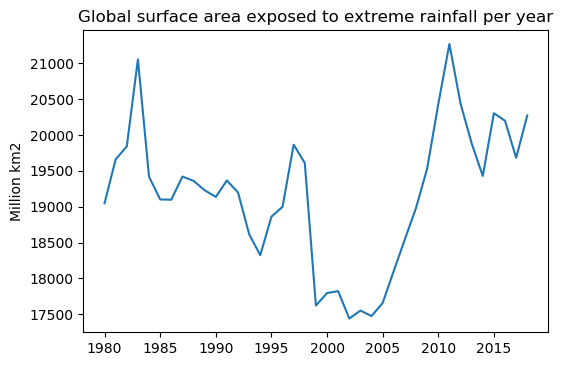

In [77]:
f, ax = plt.subplots()

(event_area_ts.groupby('time.year').sum(dim='time')/ 1_000_000).precipitation_events.plot(ax=ax)

ax.set(
    title='Global surface area exposed to extreme rainfall per year',
    xlabel='',
    ylabel='Million km2'
)

f.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png')